In [5]:
%matplotlib inline

In [46]:
from gensim.models import word2vec
import numpy as np
import pickle
from keras.utils.data_utils import get_file
import json
import nltk
import os
import glob
import threading
import bcolz
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50, identity_block
from keras.layers import Input, Lambda, AveragePooling2D, Flatten, Dense
from keras.models import Model, Sequential
import keras.backend as K

In [2]:
w2v_path = '/run/media/backman/yay/'
path = '/run/media/backman/yay/'
bc_path = '/run/media/backman/yay/throwaway.bc'

K.get_session().close()
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

RuntimeError: The Session graph is empty.  Add operations to the graph before calling run().

In [4]:
model = word2vec.KeyedVectors.load_word2vec_format(w2v_path+'GoogleNews-vectors-negative300.bin/data', binary=True)

In [5]:
model.save_word2vec_format(w2v_path+'google.txt', binary=False)

In [6]:
model = None

In [7]:
file = open(w2v_path+'google.txt')

In [8]:
lines = file.readlines()

In [9]:
def parse_w2v(l):
    i = l.index(' ')
    return l[:i], np.fromstring(l[i+1: -2], 'float32', sep=' ')

In [10]:
w2v_list = list(map(parse_w2v, lines[1:]))

In [11]:
lines = None
file.close()

In [12]:
pickle.dump(w2v_list, open(path+'w2v1.pkl','wb'))

In [13]:
w2v_list = None

In [17]:
w2v_list = pickle.load(open(path+'w2v1.pkl','rb'))

In [18]:
w2v_dict = dict(w2v_list)
words,vectors = zip(*w2v_list)

In [19]:
np.corrcoef(w2v_dict['man'], w2v_dict['king'])

array([[ 1.        ,  0.23153828],
       [ 0.23153828,  1.        ]])

In [20]:
lc_w2v = {w.lower(): w2v_dict[w] for w in reversed(words)}

In [13]:
fpath = get_file('imagenet_class_index.json', 
                 'http://www.platform.ai/models/imagenet_class_index.json', 
                 cache_subdir='models')
class_dict = json.load(open(fpath))
nclass = len(class_dict); nclass

1000

In [9]:
 nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [14]:
wordnet_nouns = list(nltk.corpus.wordnet.all_synsets(pos='n'))
with open(os.path.join(w2v_path, 'classids.txt'), 'w') as f:
    f.writelines(['n{:08d} {}\n'.format(n.offset(), n.name().split('.')[0]) for n in wordnet_nouns])

In [15]:
classids_1k = dict(class_dict.values())
classid_lines = open(path+'/classids.txt', 'r').readlines()
classids = dict(l.strip().split(' ') for l in classid_lines)
len(classids)

82115

In [21]:
syn_wv = [(k, lc_w2v[v.lower()]) for k,v in classids.items()
          if v.lower() in lc_w2v]
syn_wv_1k = [(k, lc_w2v[v.lower()]) for k,v in classids_1k.items()
          if v.lower() in lc_w2v]
syn2wv = dict(syn_wv); len(syn2wv)

51640

In [48]:
ndim = len(list(syn2wv.values())[0]); ndim

300

In [14]:
fnames = list(glob.iglob(path + 'imagenet-sample-train/train/*/*.JPEG'))
pickle.dump(fnames, open(path+'fnames.pkl','wb'))

In [8]:
fnames = pickle.load(open(path+'fnames.pkl','rb'))

In [16]:
fnames = np.random.permutation(fnames)

In [30]:
new_s = 224
n = len(fnames)

In [18]:
def _resize(img):
    shortest = min(img.width,img.height)
    resized = np.round(np.multiply(new_s/shortest, img.size)).astype(int)
    return img.resize(resized, Image.BILINEAR)

In [19]:
def resize_img(i):
    img = Image.open(fnames[i])
    s = np.array(img).shape
    if len(s)!=3 or s[2]!=3: return
    return _resize(img)

In [20]:
def resize_img_bw(i):
    return _resize(Image.open(fnames[i]).convert('L'))

In [21]:
tl = threading.local()

In [22]:
tl.place = np.zeros((new_s, new_s, 3), 'uint8')

In [23]:
arr = bcolz.carray(np.empty((0, new_s, new_s, 3), 'float32'), chunklen=32, mode='w', rootdir=bc_path)

In [24]:
def get_slice(p, n): return slice((p-n+1)//2, p-(p-n)//2)

def app_img(r):
    tl.place[:] = (np.array(r)[get_slice(r.size[1], new_s), get_slice(r.size[0], new_s)] if r else 0.)
    arr.append(tl.place)

In [33]:
step=6400
for i in tqdm(range(0, n, step)):
    with ThreadPoolExecutor(max_workers=16) as execr:
        res = execr.map(resize_img, range(i, min(i+step, n)))
        for r in res: app_img(r)
    arr.flush()

100%|██████████| 4/4 [00:41<00:00, 10.46s/it]


In [3]:
arr = bcolz.open('/run/media/backman/yay/imagenet/trn_resized_288.bc')

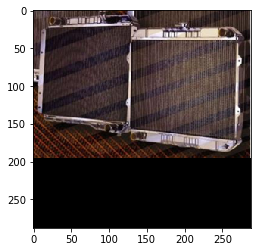

In [6]:
plt.imshow(arr[-2].astype('uint8'))

In [9]:
def get_synset(f): return f[f.rfind('/')+1:f.find('_')]

labels = list(map(get_synset, fnames))
labels[:5]

['n03481172', 'n03481172', 'n03481172', 'n03481172', 'n03481172']

In [22]:
vecs = np.stack([syn2wv[l] for l in labels]); vecs.shape

(19439, 300)

In [23]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,3))
inp = Input((288,288,3))
preproc = Lambda(lambda x: (x - rn_mean)[:, :, :, ::-1])(inp)
model = ResNet50(include_top=False, input_tensor=preproc)

In [24]:
mid_start = model.get_layer('res5b_branch2a')
mid_out = model.layers[model.layers.index(mid_start)-1]
shp=mid_out.output_shape; shp

(None, 9, 9, 2048)

In [25]:
rn_top = Model(model.input, mid_out.output)
rn_top_avg = Sequential([rn_top, AveragePooling2D((7,7))])

In [26]:
shp=rn_top_avg.output_shape; shp

(None, 1, 1, 2048)

In [27]:
features_mid = bcolz.carray(np.empty((0,)+shp[1:]), rootdir=path+'features_mid_1c_r.bc',
                           chunklen=16, mode='w')

In [28]:
def gen_features_mid(dirn):
    gen = (arr[i:min(i+128,n)] for i in range(0, len(arr), 128))
    for i,batch in tqdm(enumerate(gen)):
        features_mid.append(rn_top_avg.predict(batch[:,:,::dirn]))
        if (i%100==99): features_mid.flush()
    features_mid.flush()

In [31]:
gen_features_mid(1)


0it [00:00, ?it/s]
1it [00:03,  3.42s/it]
2it [00:05,  2.62s/it]
3it [00:07,  2.37s/it]
4it [00:08,  2.24s/it]
5it [00:10,  2.15s/it]
6it [00:12,  2.10s/it]
7it [00:14,  2.07s/it]
8it [00:16,  2.04s/it]
9it [00:18,  2.02s/it]
10it [00:20,  2.00s/it]
11it [00:21,  1.99s/it]
12it [00:23,  1.97s/it]
13it [00:25,  1.96s/it]
14it [00:27,  1.95s/it]
15it [00:29,  1.95s/it]
16it [00:30,  1.94s/it]
17it [00:32,  1.93s/it]
18it [00:34,  1.93s/it]
19it [00:36,  1.92s/it]
20it [00:38,  1.92s/it]
21it [00:40,  1.91s/it]
22it [00:42,  1.91s/it]
23it [00:43,  1.91s/it]
24it [00:45,  1.91s/it]
25it [00:47,  1.90s/it]
26it [00:49,  1.90s/it]
27it [00:51,  1.90s/it]
28it [00:53,  1.89s/it]
29it [00:54,  1.89s/it]
30it [00:56,  1.89s/it]
31it [00:58,  1.89s/it]
32it [01:00,  1.89s/it]
33it [01:02,  1.89s/it]
34it [01:04,  1.88s/it]
35it [01:05,  1.88s/it]
36it [01:07,  1.88s/it]
37it [01:09,  1.88s/it]
38it [01:11,  1.88s/it]
39it [01:13,  1.88s/it]
40it [01:15,  1.88s/it]
41it [01:17,  1.88s/it]
42it 

In [32]:
gen_features_mid(-1)


0it [00:00, ?it/s]
1it [00:01,  2.00s/it]
2it [00:03,  1.99s/it]
3it [00:05,  1.99s/it]
4it [00:07,  1.99s/it]
5it [00:09,  1.99s/it]
6it [00:11,  1.99s/it]
7it [00:13,  1.99s/it]
8it [00:15,  2.00s/it]
9it [00:17,  2.00s/it]
10it [00:19,  1.99s/it]
11it [00:21,  1.99s/it]
12it [00:23,  1.99s/it]
13it [00:25,  2.00s/it]
14it [00:27,  2.00s/it]
15it [00:29,  2.00s/it]
16it [00:31,  1.99s/it]
17it [00:33,  1.99s/it]
18it [00:35,  1.99s/it]
19it [00:37,  1.99s/it]
20it [00:39,  1.99s/it]
21it [00:41,  1.99s/it]
22it [00:43,  1.99s/it]
23it [00:45,  1.99s/it]
24it [00:47,  1.98s/it]
25it [00:49,  1.98s/it]
26it [00:51,  1.98s/it]
27it [00:53,  1.98s/it]
28it [00:55,  1.98s/it]
29it [00:57,  1.98s/it]
30it [00:59,  1.97s/it]
31it [01:01,  1.98s/it]
32it [01:03,  1.98s/it]
33it [01:05,  1.98s/it]
34it [01:07,  1.98s/it]
35it [01:09,  1.98s/it]
36it [01:11,  1.98s/it]
37it [01:13,  1.98s/it]
38it [01:15,  1.98s/it]
39it [01:17,  1.98s/it]
40it [01:19,  1.98s/it]
41it [01:20,  1.97s/it]
42it 

In [33]:
features_mid.shape

(38878, 1, 1, 2048)

In [38]:
rn_bot_inp = Input(shp[1:])
x = rn_bot_inp
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
x = Flatten()(x)
rn_bot = Model(rn_bot_inp, x)
rn_bot.output_shape

(None, 2048)

In [39]:
for i in range(len(rn_bot.layers)-2):
    rn_bot.layers[-i-2].set_weights(model.layers[-i-2].get_weights())

In [40]:
features_last = rn_bot.predict(features_mid, batch_size=128)

In [42]:
features_last = bcolz.carray(features_last, rootdir=path+'features_last_r.bc', 
                             chunklen=64, mode='w')

In [44]:
features_last = bcolz.open(path+'features_last_r.bc')[:]

In [49]:
lm_inp = Input(shape=(2048,))
lm = Model(lm_inp, Dense(ndim)(lm_inp))

In [50]:
def cos_distance(y_true, y_pred):
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    return K.mean(1 - K.sum((y_true * y_pred), axis=-1))

In [51]:
lm.compile('adam','cosine_proximity')

In [52]:
lm.evaluate(features_last, vecs, verbose=0)

ValueError: Input arrays should have the same number of samples as target arrays. Found 38878 input samples and 19439 target samples.